In [2]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
np.random.seed(42)
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
df = pd.read_csv('../../data/judge-1377884607_tweet_product_company.csv',encoding='unicode-escape')
df.sample(8)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5558,RT @mention best thing abt @mention for #SXSW?...,NaN,No emotion toward brand or product
8350,Gary is starting a new show &quot;Daily Grape&...,NaN,No emotion toward brand or product
2303,"The walk by Lady Bird Lake was lovely, but Goo...",Other Google product or service,Negative emotion
927,C34: ItÛªs Not a Retreat! {link} [codes valid...,NaN,No emotion toward brand or product
1963,Holler Gram for iPad on the iTunes App Store: ...,iPad or iPhone App,Positive emotion
1672,"I asked, &quot;Why should(n't) I get an iPad 2...",NaN,No emotion toward brand or product
4475,"LOL, I don't see a single PC user around meÛÓ...",Apple,Positive emotion
4262,"Video: Tim Wu explains to me #netneutrality, i...",NaN,No emotion toward brand or product


In [4]:
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
sw = stopwords.words('english')

In [14]:
extra_sw = pd.read_csv('../asp_notebooks/apl_prd_custom_stop.csv')
extra_sw = list(extra_sw['tweet_text'])

In [15]:
sw = sw + extra_sw

In [16]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in stop_words]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [8]:
regex_token

NameError: name 'regex_token' is not defined

In [18]:
X = df.tweet_text.astype('str')
y = df.is_there_an_emotion_directed_at_a_brand_or_product

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

In [20]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adamroth/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adamroth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[0:5]

['good design mean get simple mention talk text way impact healthcare africa forget iphone amhealth sxsw',
 'wish sxsw see rumor demo mention new social network circle link mention',
 'rt mention problem stop link edchat musedchat sxsw sxswi classical newtwitter',
 'mention new ipad speech therapy communication showcased sxsw conference link augcomm hcsm mhealth',
 'ipad queue epic sxsw link']

In [22]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

In [23]:
cv = CountVectorizer()

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [24]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
prior_1 = y_t.value_counts()['Positive emotion']/len(y_t)
prior_0 = y_t.value_counts()['Negative emotion']/len(y_t)
prior_2 = y_t.value_counts()['No emotion toward brand or product']/len(y_t)
prior_3 = y_t.value_counts()['I can\'t tell']/len(y_t)
print(prior_0, prior_1, prior_2, prior_3)
print(np.log(prior_1))


0.06257332811888933 0.3318341806804849 0.5879937426671881 0.01759874853343762
-1.1031198906169057


In [26]:
mnb.class_log_prior_

array([-4.03992749, -2.77141616, -0.53103897, -1.10311989])

In [27]:
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)
cv.vocabulary_

{'wave': 5682,
 'buzz': 733,
 'rt': 4430,
 'mention': 3240,
 'interrupt': 2666,
 'regularly': 4269,
 'schedule': 4499,
 'sxsw': 5060,
 'geek': 2103,
 'program': 4058,
 'big': 536,
 'news': 3477,
 'link': 3006,
 'google': 2183,
 'circle': 912,
 'ipad': 2691,
 'sell': 4554,
 'retail': 4341,
 'store': 4943,
 'except': 1759,
 'pop': 3943,
 'austin': 347,
 'igottagetit': 2524,
 'way': 5684,
 'matt': 3195,
 'fricking': 2025,
 'damon': 1247,
 'party': 3746,
 'maggie': 3119,
 'mae': 3115,
 'part': 3738,
 'presentation': 4011,
 'good': 2178,
 'thing': 5224,
 'crash': 1167,
 'instead': 2640,
 'work': 5804,
 'best': 519,
 'iphone': 2696,
 'android': 194,
 'major': 3129,
 'new': 3471,
 'social': 4775,
 'network': 3465,
 'call': 751,
 'possibly': 3965,
 'today': 5288,
 'sxswi': 5077,
 'sxswparty': 5088,
 'upstairs': 5524,
 'maes': 3116,
 'th': 5195,
 'st': 4889,
 'temp': 5171,
 'congress': 1056,
 'attendee': 324,
 'excuse': 1766,
 'walk': 5654,
 'around': 285,
 'essential': 1707,
 'water': 5679,
 '

In [28]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)
print(accuracy_score(y_val, y_hat))
print(confusion_matrix(y_val, y_hat))

0.6498533724340176
[[  0   0  20   7]
 [  0  18  49  39]
 [  0   4 823 205]
 [  0   1 272 267]]


In [17]:
y_val.value_counts()

No emotion toward brand or product    1032
Positive emotion                       540
Negative emotion                       106
I can't tell                            27
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [29]:
confusion_matrix(y_val,y_hat)

array([[  0,   0,  20,   7],
       [  0,  18,  49,  39],
       [  0,   4, 823, 205],
       [  0,   1, 272, 267]])

In [19]:
#Not great, but not bad for a first few models

In [20]:
type(cv.vocabulary_)

dict

### Visualization of word counts

In [30]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

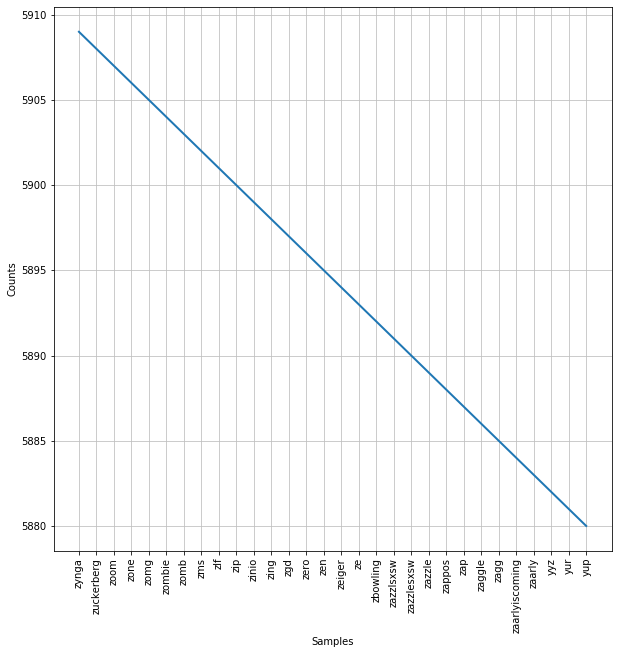

In [31]:
fdist = FreqDist(cv.vocabulary_)
plt.figure(figsize=(10,10))
fdist.plot(30)

,aapl,aaron,aarpbulletin,ab,abandon,abc,ability,able,abnormal,abound,...,zip,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga
9089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
715,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
